# Setting up the data and causal model: CausalityDataset

This notebook demonstrates how to use and configure `CausalityDataset` using an arbitrary `pd.DataFrame`.


In [44]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy, causaltune, and FLAML from source
root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

try:
    import flaml
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "FLAML"))
    
    
    
from causaltune import CausalTune
from causaltune.datasets import synth_ihdp, iv_dgp_econml, generate_non_random_dataset
from causaltune.data_utils import CausalityDataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Random assignment 
We first illustrate the model setup with a subset of data from the Infant Health and Development Program (IHDP).

In [60]:
df = synth_ihdp(return_df=True).iloc[:,:5]
display(df.head())

,treatment,y_factual,x1,x2,x3
0,1,5.599916,-0.528603,-0.343455,1.128554
1,0,6.875856,-1.736945,-1.802002,0.383828
2,0,2.996273,-0.807451,-0.202946,-0.360898
3,0,1.366206,0.390083,0.596582,-1.850350
4,0,1.963538,-1.045229,-0.602710,0.011465


Generally, at least three arguments have to be supplied to `CausalityDataset`:
- `data`: input dataframe
- `treatment`: name of treatment column
- `outcomes`: list of names of outcome columns; provide as list even if there's just one outcome of interest

In addition, if the propensities to treat are known, then provide the corresponding column name(s) via `propensity_modifiers`.

In [4]:
cd = CausalityDataset(data=df, treatment='treatment', outcomes=['y_factual'])

The next step is to use `cd.preprocess_dataset()` to deal with missing values, remove outliers etc.

In [5]:
cd.preprocess_dataset()

The causal model is built by assuming that all remaining features are `effect_modifiers`

In [17]:
print(cd.effect_modifiers)

['x1', 'x2', 'x3']


Subsequently, use the preprocessed `CausalityDataset` object for training as follow: `CausalTune.fit(cd, outcome='y_factual')`.

In [ ]:
ct = CausalTune(components_time_budget=5,)   
ct.fit(data=cd, outcome='y_factual')

The causal graph that CausalTune uses is 

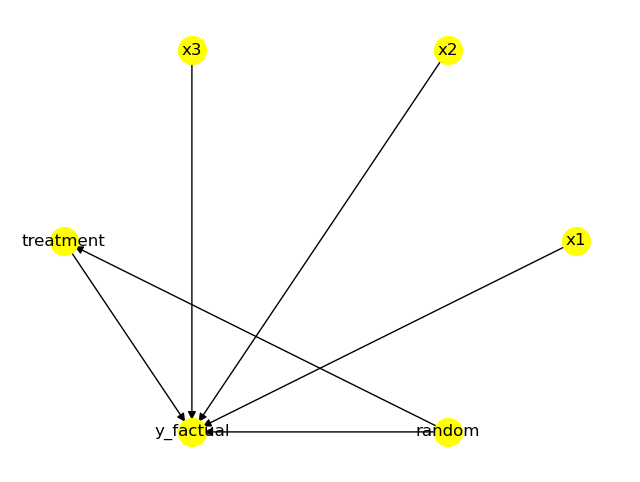

In [10]:
%matplotlib inline
ct.causal_model.view_model()

*Note that the variable `random` can be ignored and has no real meaning for the causal model.*

#### Adding common causes

If we had reason to assume that for instance `x1` and `x2` are `common causes` instead of `effect modifiers`, this can be made explicit:


In [61]:
cd = CausalityDataset(data=df, treatment='treatment', outcomes=['y_factual'], common_causes=['x1', 'x2'])

The causal graph becomes

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decr

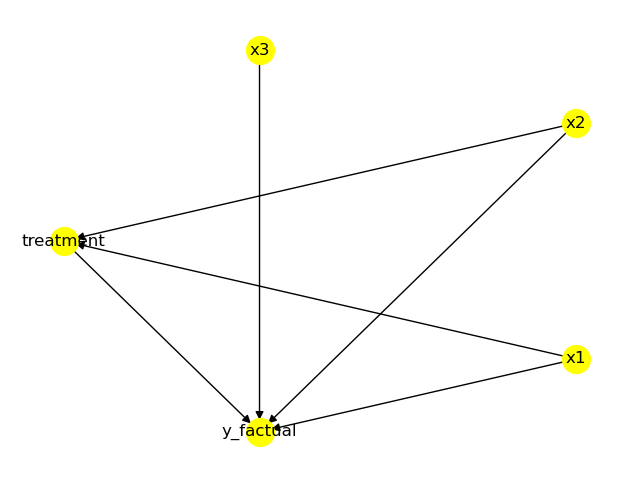

In [62]:
cd.preprocess_dataset()
ct = CausalTune(components_time_budget=5,)   
ct.fit(data=cd, outcome='y_factual')
ct.causal_model.view_model()

For how to proceed further with CausalTune, see for instance [here](https://github.com/py-why/causaltune/blob/main/notebooks/Random%20assignment%2C%20binary%20CATE%20example.ipynb)

### Instrumental variable identification

In other problems of causal inference, one may seek to follow an instrumental variable approach ([Example notebook](https://github.com/py-why/causaltune/blob/main/notebooks/Comparing%20IV%20Estimators.ipynb)). 

In [34]:
#load data
df = iv_dgp_econml(p=4).data
del df['random']
print(df.head(5))

         x1        x2        x3        x4          y  treatment  Z
0 -2.167807 -0.081599  0.354765 -0.470893   0.950792          0  1
1  0.206365  1.144597 -1.338532 -0.237026  18.188874          1  1
2 -0.497604  1.264037  1.282048  1.036047   6.519928          0  0
3  1.092089  0.331639 -0.623374  0.321355   9.221536          0  0
4 -0.126635 -1.717113  0.645309 -1.320294  11.088779          1  1


Suppose we want to use $Z$ as an instrument.

In [35]:
cd = CausalityDataset(
    data=df, 
    treatment='treatment',
    outcomes=['y'],
    instruments=['Z']
    )
cd.preprocess_dataset()

In [41]:
print('Outcomes:', cd.outcomes)
print('Treatment:', cd.treatment)
print('Instruments:', cd.instruments)
print('Effect modifiers:', cd.effect_modifiers)

Outcomes: ['y']
Treatment: treatment
Instruments: ['Z']
Effect modifiers: ['x1', 'x2', 'x3', 'x4']


In [ ]:
ct = CausalTune(
    components_time_budget=5,
    estimator_list=['iv.econml.iv.dml.DMLIV']
    )   
ct.fit(data=cd, outcome='y')

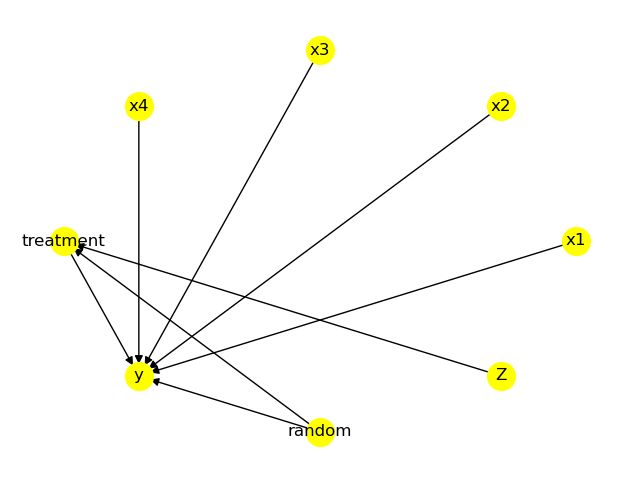

In [43]:
ct.causal_model.view_model()

### Propensity modifiers

If there are well-known propensity modifiers, it is also possible to make those explicit. This can, e.g., be used to pass them directly into the model instead of fitting a propensity weight model (for more details, see [here](https://github.com/py-why/causaltune/blob/main/notebooks/Propensity%20Model%20Selection.ipynb)).

In [54]:
#load data
df = generate_non_random_dataset().data
del df['random']
print(df.head(5))

   T         Y        X1        X2        X3        X4        X5  propensity
0  1  0.651561  1.266634 -1.493090 -0.139367 -1.234455  0.115191    0.314804
1  1  1.499142  0.977774  0.426410  0.709403 -0.371737 -1.062126    0.656799
2  0 -1.504549  0.037244  0.522880 -0.896096  0.838664 -0.006262    0.705601
3  1 -2.231536 -1.008786  0.058282  0.322617  0.213959  0.256430    0.368792
4  1  1.108775  1.296887 -0.063358 -1.825230  0.541003  0.221827    0.774054


In [55]:
cd = CausalityDataset(
    data=df, 
    treatment='T',
    outcomes=['Y'],
    propensity_modifiers=['propensity']
    )
cd.preprocess_dataset()

In [58]:
print('Outcomes:', cd.outcomes)
print('Treatment:', cd.treatment)
print('Propensity Modifiers:', cd.propensity_modifiers)
print('Effect modifiers:', cd.effect_modifiers)

Outcomes: ['Y']
Treatment: T
Propensity Modifiers: ['propensity']
Effect modifiers: ['X1', 'X2', 'X3', 'X4', 'X5']


In [ ]:
ct = CausalTune(
    components_time_budget=5,
)   
ct.fit(data=cd, outcome='Y')

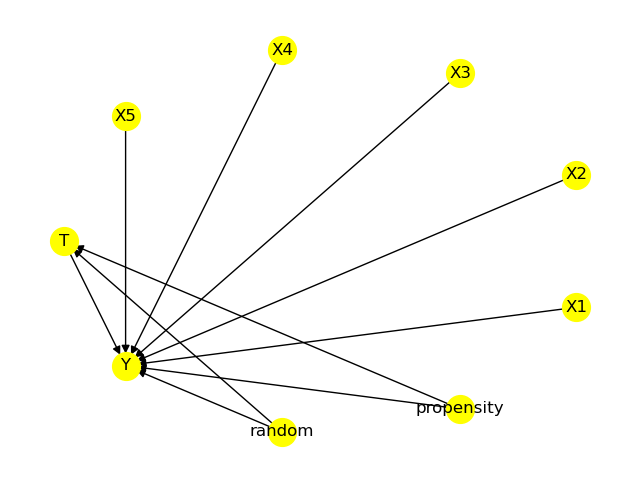

In [57]:
ct.causal_model.view_model()